# ADS Thesis Project - Random Forest and Boosting Models

**Authors: Marion Späth (2772981)**


This notebook documents the Random Forest and Boosting Models for both cattle and goat herders.
The datasets have been created in the R file for the Elastic Net.

### Import libraries

In [2]:
#!pip install shap
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import shap

import os

from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import cross_val_score
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error

# with pickle we can save the model, helps with long computation times
import pickle

### Import datasets

In [3]:
pd.set_option('display.max_columns', None) # show all columns in output

# set working directory
os.chdir('C:/Users/Marion Späth/Desktop/ADS/Thesis/Data')

# load train and test data (previously created in the ElasticNet notebook)
train_cattle = pd.read_csv("train_goat_df.csv")
train_goat = pd.read_csv("train_cattle_df.csv")
test_cattle = pd.read_csv("test_goat_df.csv")
test_goat = pd.read_csv("test_cattle_df.csv")
test_goat.head(2)

,afm_language,age_constant_z,agric_land,amh_language,educ_recoded_constant,eng_language,expend,irrigated_land_bin,number_minors_z,educ_child_recoded,activity_child_recoded,household_description,number_adults_z,main_info_source_recoded,religion_recoded,owns_phone,household_moved,why_not_purchase_recoded,know_vip,trust_vip,resid_mixed
0,No,-0.496108,Yes,No,Never attended,No,0,0,-0.159894,Elementary,Student,Fully settled: The whole of the household (all...,-0.213343,Interpersonal Sources,Traditional/Wakefata,0,No,"Financial, Practical, and Situational Constraints",Yes,Yes,-0.597265
1,No,0.105843,Yes,No,Never attended,No,0,1,-1.389756,Never attended school,Working with Livestock,Fully settled: The whole of the household (all...,1.286942,Interpersonal Sources,Traditional/Wakefata,0,No,"Financial, Practical, and Situational Constraints",Yes,Yes,0.254622


### Check datatypes

In [9]:
train_cattle.dtypes

afm_language                 object
age_constant_z              float64
agric_land                   object
amh_language                 object
educ_recoded_constant        object
eng_language                 object
expend                        int64
irrigated_land_bin            int64
number_minors_z             float64
educ_child_recoded           object
activity_child_recoded       object
household_description        object
number_adults_z             float64
main_info_source_recoded     object
religion_recoded             object
owns_phone                    int64
household_moved              object
why_not_purchase_recoded     object
know_vip                     object
trust_vip                    object
resid_mixed                 float64
dtype: object

### Prepare Datasets for Models

In [7]:
# Prepare categorical variables but creating dummies
train_cattle = pd.get_dummies(train_cattle, drop_first='True')
train_goat = pd.get_dummies(train_goat, drop_first='True')
test_cattle = pd.get_dummies(test_cattle, drop_first='True')
test_goat = pd.get_dummies(test_goat, drop_first='True')

In [8]:
# Prepare X and Y training sets for models
X_cattle = train_cattle.copy
X_cattle = train_cattle.drop("resid_mixed", axis=1)
X_goat = train_goat.copy
X_goat = train_goat.drop("resid_mixed", axis=1)

Y_cattle = train_cattle["resid_mixed"]
Y_goat = train_goat["resid_mixed"]

# Random Forest

#### Set Up Hyperparameters and Performance Indicators

Prepare cross-validation using grid search including all available hyperparameters and specifying performance metrics to incluede the (negative) mean squared error, (negative) mean absolute error, and R Squared. Sklearn calculate the negative values so that the interpretation of "the higher the better" is valid across all performance metrics.

In [81]:
rf = RandomForestRegressor(random_state=0)

cv_params = {'max_depth': [5,7,10,15, None], 
             'min_samples_leaf': [2,4,6,10],
             'min_samples_split': [2,3,4,10],
             'max_features': [2,5,10,15],
             'n_estimators': [75, 100, 125, 150]
             }  

scoring = ['neg_mean_squared_error', 'r2', 'neg_mean_absolute_error']

rf_cv = GridSearchCV(rf, cv_params, scoring=scoring, cv=10, refit='neg_mean_absolute_error')

#### Fit Model

Fit the model. Runtime is >45mins.

In [ ]:
%%time

#rf_cv.fit(X_cattle, Y_cattle)

CPU times: total: 56min 20s
Wall time: 56min 30s


GridSearchCV(cv=10, estimator=RandomForestRegressor(random_state=0),
             param_grid={'max_depth': [5, 7, 10, 15, None],
                         'max_features': [2, 5, 10, 15],
                         'min_samples_leaf': [2, 4, 6, 10],
                         'min_samples_split': [2, 3, 4, 10],
                         'n_estimators': [75, 100, 125, 150]},
             refit='neg_mean_absolute_error',
             scoring=['neg_mean_squared_error', 'r2',
                      'neg_mean_absolute_error'])

In [ ]:
# Pickle the model
#with open('C:/Users/Marion Späth/Desktop/ADS/Thesis/Data/'+'rf_cv_model_CATTLE.pickle', 'wb') as to_write:
#    pickle.dump(rf_cv, to_write)


In [9]:
# Read in pickled model
with open('C:/Users/Marion Späth/Desktop/ADS/Thesis/Data/' + 'rf_cv_model_CATTLE.pickle', 'rb') as to_read:
    rf_cv = pickle.load(to_read)

Extract best hyperparameter specifications and best model performance.

In [10]:
print("Best hyperparameters:\n", rf_cv.best_params_ , "\n")
print("Performance based on best hyperparameter specification:\n", rf_cv.best_score_)

Best hyperparameters:
 {'max_depth': 7, 'max_features': 5, 'min_samples_leaf': 2, 'min_samples_split': 2, 'n_estimators': 150} 

Performance based on best hyperparameter specification:
 -1.063051275254341


### Extract Feature Importance Scores

In [11]:
# Get feature importances from the best model
importances = rf_cv.best_estimator_.feature_importances_

# Pair them with feature names and sort by importance
feature_names = X_cattle.columns
importance_df = pd.DataFrame({'Feature': feature_names, 'Importance': importances})
importance_df = importance_df.sort_values(by='Importance', ascending=False)

print(importance_df)

                                              Feature  Importance
0                                      age_constant_z    0.138766
3                                     number_minors_z    0.112724
4                                     number_adults_z    0.074352
33                                      trust_vip_Yes    0.042988
28                                household_moved_Yes    0.041106
31  why_not_purchase_recoded_Lack of Awareness or ...    0.039918
22  household_description_Not settled: The whole h...    0.039795
25  main_info_source_recoded_Professional and Orga...    0.035919
1                                              expend    0.029956
24  main_info_source_recoded_Media, Community-Base...    0.027770
5                                          owns_phone    0.027604
7                                      agric_land_Yes    0.024842
14           educ_child_recoded_Never attended school    0.024451
6                                    afm_language_Yes    0.023818
23  househ

### Investigate Partial Dependences and Interactions

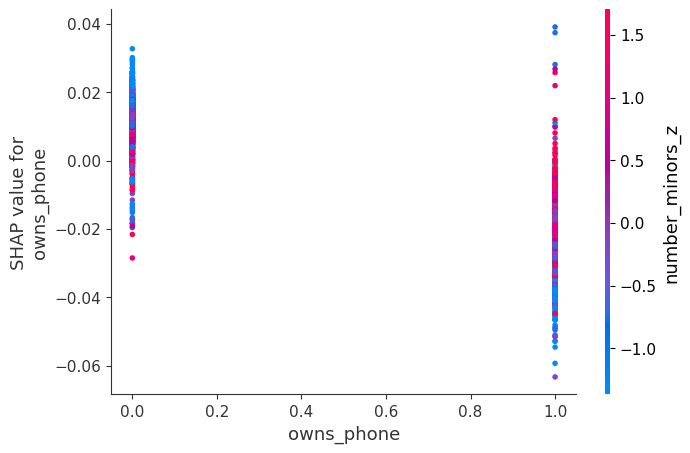

In [12]:
# 1. Best model
best_model = rf_cv.best_estimator_

# 2. Explainer
explainer = shap.TreeExplainer(best_model)

# 3. Sample data (if large)
#X_sample = X_cattle.sample(n=1000, random_state=0)
shap_interaction_values = explainer.shap_interaction_values(X_cattle)

# 4. Compute SHAP values
shap_values = explainer.shap_values(X_cattle)

# 5. SHAP dependence plot with interaction
shap.dependence_plot(
    ind='owns_phone',             # Primary feature
    shap_values=shap_values,
    features=X_cattle,               # Original features
    interaction_index='number_minors_z'       # Feature to interact with
)

c:\anaconda_custom\Lib\site-packages\shap\plots\_beeswarm.py:1153: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all Axes decorations.
  pl.tight_layout()


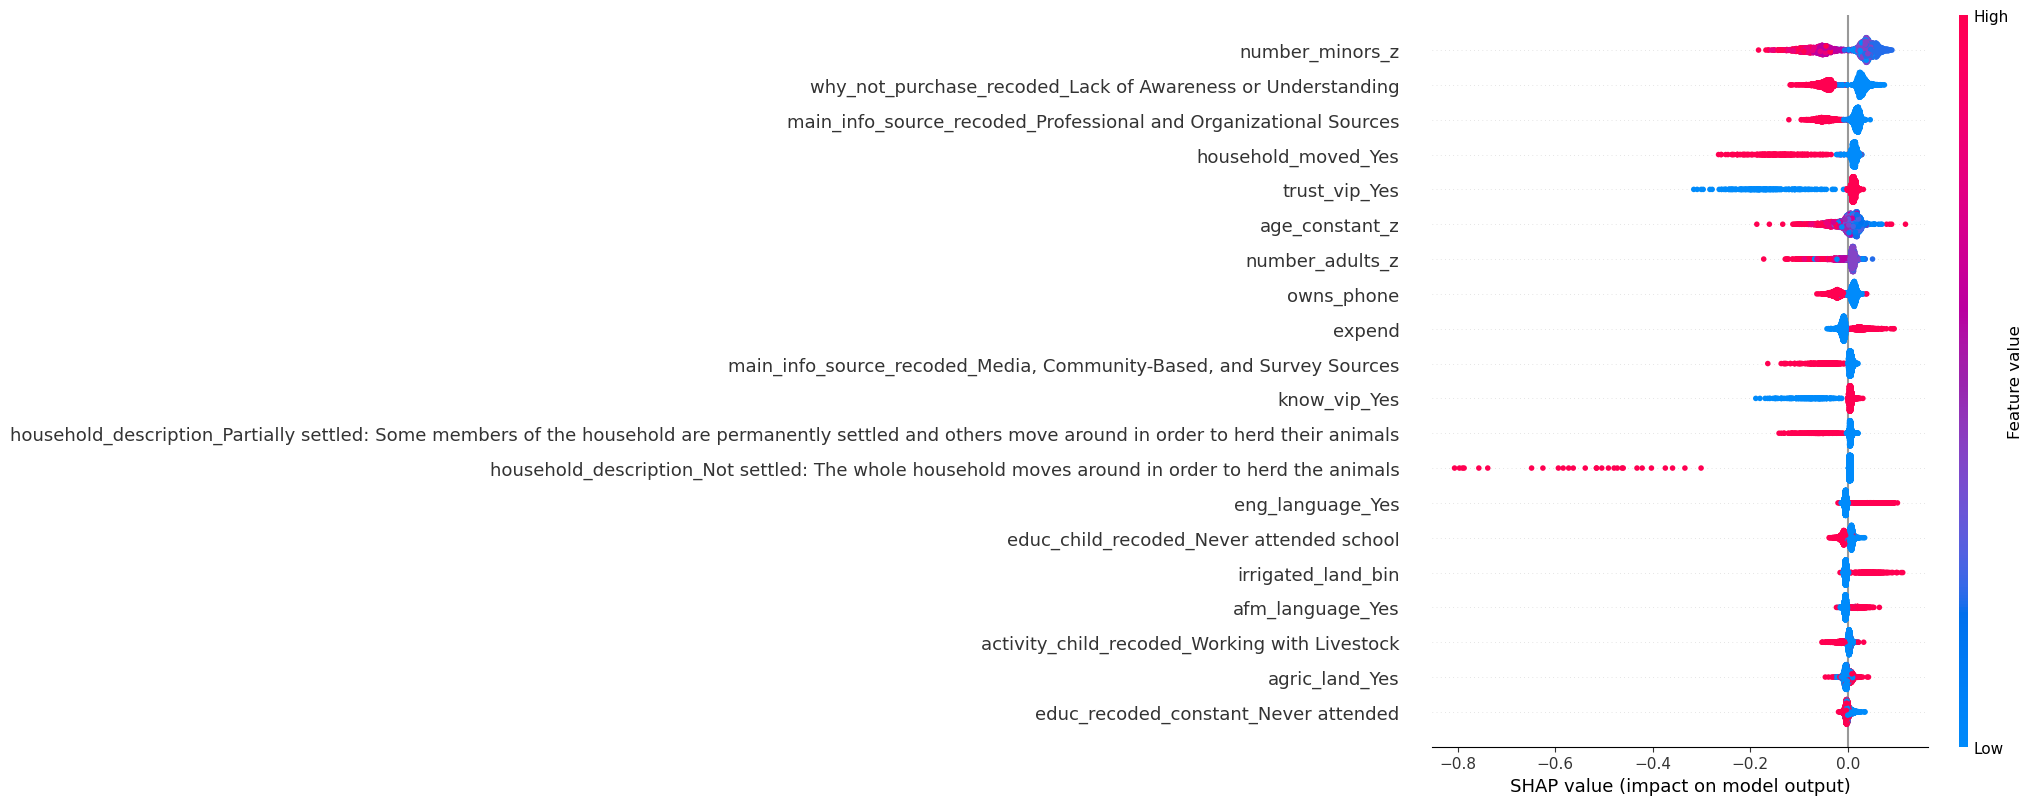

In [14]:
# Plot SHAP summary
shap.summary_plot(
    shap_values,
    X_cattle,
    plot_type="dot",
)

In [ ]:
# Get interaction strengths
interaction_strengths = np.abs(shap_interaction_values).sum(axis=0)
np.fill_diagonal(interaction_strengths, 0)  # Remove main effects

# Convert to DataFrame for easier reading
interaction_df = pd.DataFrame(
    interaction_strengths,
    index=X_cattle.columns,
    columns=X_cattle.columns
)

# Sort by most interactive partners with 'owns_phone'
interaction_df.loc['owns_phone'].sort_values(ascending=False).head(10)

number_minors_z                                                2.835577
why_not_purchase_recoded_Lack of Awareness or Understanding    1.243557
age_constant_z                                                 1.219084
expend                                                         1.091023
number_adults_z                                                0.913836
trust_vip_Yes                                                  0.873630
educ_recoded_constant_Never attended                           0.762300
educ_child_recoded_Never attended school                       0.732521
educ_recoded_constant_Nursery                                  0.709024
household_moved_Yes                                            0.689859
Name: owns_phone, dtype: float64

In [ ]:
# Step 1: Create interaction values (this returns a 3D array)
shap_interaction_values = explainer.shap_interaction_values(X_cattle)

# Step 2: Sum absolute interaction strengths across all samples
interaction_strengths = np.abs(shap_interaction_values).sum(axis=0)

# Step 3: Zero out the diagonal if you only want true interactions (not main effects)
np.fill_diagonal(interaction_strengths, 0)

# Step 4: Create a labeled DataFrame to inspect

feature_names = X_cattle.columns
interaction_df = pd.DataFrame(
    interaction_strengths,
    index=feature_names,
    columns=feature_names
)

# Step 5: Sort to find strongest interactions
interaction_df_long = interaction_df.stack().reset_index()
interaction_df_long.columns = ['Feature_1', 'Feature_2', 'Interaction_Strength']
interaction_df_long = interaction_df_long[interaction_df_long['Feature_1'] != interaction_df_long['Feature_2']]
interaction_df_long = interaction_df_long.sort_values(by='Interaction_Strength', ascending=False)

# Show top interactions
interaction_df_long.head(10)

,Feature_1,Feature_2,Interaction_Strength
127,number_minors_z,main_info_source_recoded_Professional and Orga...,3.783137
853,main_info_source_recoded_Professional and Orga...,number_minors_z,3.783137
107,number_minors_z,owns_phone,2.835577
173,owns_phone,number_minors_z,2.835577
1082,why_not_purchase_recoded_Lack of Awareness or ...,household_moved_Yes,2.743519
983,household_moved_Yes,why_not_purchase_recoded_Lack of Awareness or ...,2.743519
3,age_constant_z,number_minors_z,2.578850
102,number_minors_z,age_constant_z,2.578850
126,number_minors_z,"main_info_source_recoded_Media, Community-Base...",2.344879
819,"main_info_source_recoded_Media, Community-Base...",number_minors_z,2.344879


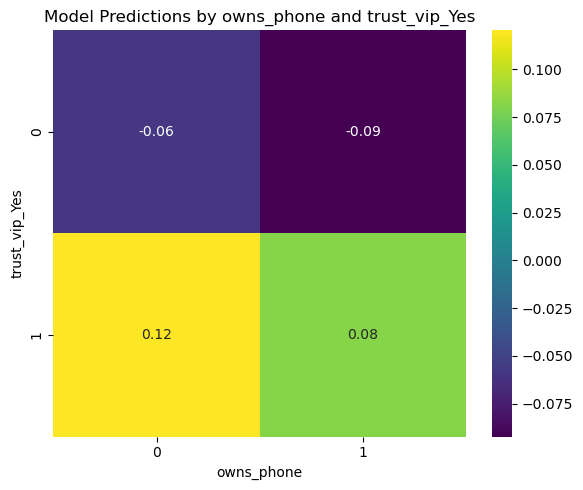

In [ ]:
# Pick the two features you want to vary
feature1 = 'owns_phone'
feature2 = 'trust_vip_Yes'

# Number of values in the grid (2 if binary, or more if continuous)
# You can also auto-detect this:
if set(X_cattle[feature1].unique()) <= {0, 1} and set(X_cattle[feature2].unique()) <= {0, 1}:
    grid1 = [0, 1]
    grid2 = [0, 1]
else:
    grid1 = np.linspace(X_cattle[feature1].min(), X_cattle[feature1].max(), 50)
    grid2 = np.linspace(X_cattle[feature2].min(), X_cattle[feature2].max(), 50)

# Create grid of all combinations
grid = pd.DataFrame([
    {feature1: v1, feature2: v2}
    for v1 in grid1
    for v2 in grid2
])

# Fill all other features with mean values
for col in X_cattle.columns:
    if col not in [feature1, feature2]:
        grid[col] = X_cattle[col].mean()

# Align column order to match training data
grid = grid[X_cattle.columns]

# Predict with best model
grid['prediction'] = rf_cv.best_estimator_.predict(grid)

# Pivot into matrix for heatmap
heatmap_data = grid.pivot(index=feature2, columns=feature1, values='prediction')

# Plot
plt.figure(figsize=(6, 5))
sns.heatmap(heatmap_data, cmap='viridis', annot=True, fmt=".2f")
plt.title(f"Model Predictions by {feature1} and {feature2}")
plt.xlabel(feature1)
plt.ylabel(feature2)
plt.tight_layout()
plt.show()


In [ ]:
# Feature pair
feature1 = 'owns_phone'             # binary
feature2 = 'number_adults_z'       # continuous

# Define resolution (you can adjust this for smoothness)
num_points = 30

# Create grids for the 2 features
grid1 = [0, 1] if set(X_cattle[feature1].unique()) <= {0, 1} else np.linspace(X_cattle[feature1].min(), X_cattle[feature1].max(), num_points)
grid2 = np.linspace(X_cattle[feature2].min(), X_cattle[feature2].max(), num_points)

# Build the full grid
grid = pd.DataFrame([
    {feature1: v1, feature2: v2}
    for v1 in grid1
    for v2 in grid2
])

# Add average values for all other features
for col in X_cattle.columns:
    if col not in [feature1, feature2]:
        grid[col] = X_cattle[col].mean()

# Align columns
grid = grid[X_cattle.columns]

# Predict
grid['prediction'] = rf_cv.best_estimator_.predict(grid)

# Reshape for heatmap
heatmap_data = grid.pivot(index=feature2, columns=feature1, values='prediction')

# Plot clean heatmap (without text annotations)
plt.figure(figsize=(6, 5))
sns.heatmap(heatmap_data, cmap='viridis', cbar_kws={'label': 'Predicted Outcome'})
plt.title(f"Model Predictions by {feature1} and {feature2}")
plt.xlabel(feature1)
plt.ylabel(feature2)
plt.tight_layout()
plt.show()


AttributeError: 'GridSearchCV' object has no attribute 'best_estimator_'

# Boosting with LightGBM

In [16]:
!pip install lightgbm

   ---------------------------------------- 0.0/1.5 MB ? eta -:--:--
   ---------------------------------------- 1.5/1.5 MB 12.7 MB/s eta 0:00:00


In [ ]:
import lightgbm as lgb
from sklearn.model_selection import GridSearchCV, KFold

X_cattle.columns = X_cattle.columns.str.replace('[^A-Za-z0-9_]+', '_', regex=True)

# LightGBM model setup (no categorical handling needed)
lgb_model = lgb.LGBMRegressor(boosting_type='gbdt', random_state=42)

# Define broad hyperparameter grid
param_grid = {
    'num_leaves': [31, 50, 100],
    'max_depth': [ 1,5,10, 20],
    'learning_rate': [0.01, 0.05, 0.1],
    'n_estimators': [50, 100, 200],
    'min_child_samples': [10, 20, 50],
    'subsample': [0.6, 0.8, 1.0],
    'colsample_bytree': [0.6, 0.8, 1.0],
    'reg_alpha': [0.0, 0.1, 1.0],
    'reg_lambda': [0.0, 0.1, 1.0],
}

# 10-fold cross-validation setup
cv = KFold(n_splits=10, shuffle=True, random_state=42)

scoring = ['neg_mean_squared_error', 'r2', 'neg_mean_absolute_error']


# Grid search
grid = GridSearchCV(
    estimator=lgb_model,
    param_grid=param_grid,
    scoring=scoring,
    cv=cv,
    verbose=1,
    n_jobs=-1,
    refit='neg_mean_absolute_error'
)

In [41]:
# Fit model (X and y are preprocessed)
grid.fit(X_cattle, Y_cattle)

Fitting 10 folds for each of 43740 candidates, totalling 437400 fits


c:\anaconda_custom\Lib\site-packages\joblib\externals\loky\process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


KeyboardInterrupt: 

In [ ]:
# Extract best model
best_model = grid.best_estimator_

# Print best hyperparameters
print("Best parameters:")
print(grid.best_params_)

best_model.best_score_

Best parameters:
{'colsample_bytree': 0.6, 'learning_rate': 0.1, 'max_depth': 10, 'min_child_samples': 20, 'n_estimators': 20, 'num_leaves': 20, 'reg_alpha': 0.1, 'reg_lambda': 0.0, 'subsample': 0.6}


defaultdict(collections.OrderedDict, {})

In [ ]:
with open('C:/Users/Marion Späth/Desktop/ADS/Thesis/Data/'+'boost_cv_model_CATTLE.pickle', 'wb') as to_write:
    pickle.dump(rf_cv, to_write)

In [39]:
grid.best_score_

-1.0408429421587964